In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA, FastICA
from sklearn import linear_model
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
%matplotlib inline
import seaborn as sns; sns.set()
import progressbar as pb
import time 
import math
import os
import turchin

In [3]:
# read csv/excel data files 
dataPath1 = os.path.abspath(os.path.join("./..","data","pnas_data1.csv")) #20 imputed sets

pnas_data1 = pd.read_csv(dataPath1)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [4]:
# format data 

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']
feature_time = ['Time'] + features
# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
times = pnas_data1.loc[:, ['Time']].values
ngas = pnas_data1.NGA.unique().tolist()
P, D, Q = turchin.svd(data_mat)

Q = normalize(Q, axis=0)
data = np.matmul(data_mat, Q.T)

In [136]:
#Gaussian Mixture Model 
#fit GMM
gmm = GMM(n_components=2).fit(data_mat)
cov = gmm.covariances_
prob_distr = gmm.predict_proba(data_mat)

# determine to which of the two gaussians each data point belongs by looking at probability distribution 
if gmm.weights_[0] < gmm.weights_[1]:
    gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] >= prob_distr[i][1]]
    gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] >= prob_distr[j][0]]
else:
    gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] <= prob_distr[i][1]]
    gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] <= prob_distr[j][0]]


gauss1_time = [times[i] for i in gauss1_idx] # time for the first gaussian data
gauss2_time = [times[j] for j in gauss2_idx] # time for the second gaussian data

gauss1_point = [data_mat[i] for i in gauss1_idx] # 9-d data point for the first gaussian
gauss2_point = [data_mat[j] for j in gauss2_idx] # 9-d data point for the second gaussian

def dummy(data, ngas):
    """
    Given a gaussian projection data and a list of unique ngas, 
    """
    # dummy variables for NGAs for fixed effects
    dummy = [[1 if pnas_data1.loc[[point]].NGA.tolist()[0] == nga else 0 for nga in ngas] for point in data]
    return np.asarray(dummy)

dummy1 = dummy(gauss1_idx, ngas)
dummy2 = dummy(gauss2_idx, ngas)

In [201]:
gmm = GMM(n_components=2).fit(data)
cov = gmm.covariances_

# main eigenvectors for covariances of each gaussians
eigval91, eigvec1 = np.linalg.eig(cov[0])
eigval2, eigvec2 = np.linalg.eig(cov[1])

# find the eigenvector corresponding to the largest eigenvalue for each of the two gaussians
max_eigvec1 = eigvec1[:, np.argmax(max(eigval1))] 
max_eigvec2 = eigvec2[:, np.argmax(max(eigval2))]

# max_eigvec1 = np.asarray([(i**2)/math.sqrt(sum([k**2 for k in max_eigvec1])) for i in max_eigvec1])
# max_eigvec2 = np.asarray([(j**2)/math.sqrt(sum([k**2 for k in max_eigvec2])) for j in max_eigvec2])

gauss1_proj = np.matmul(gauss1_point, max_eigvec1)
gauss2_proj = np.matmul(gauss2_point, max_eigvec2)

gauss1_proj = np.vstack((gauss1_proj.T, dummy1.T)).T
gauss2_proj = np.vstack((gauss2_proj.T, dummy2.T)).T

assert gauss1_proj.shape[1] == 31
assert gauss2_proj.shape[1] == 31




In [6]:
# Multiple linear regression over time
ols1 = linear_model.LinearRegression()
ols2 = linear_model.LinearRegression()
model1 = ols1.fit(gauss1_time, gauss1_point)
print(gauss1_time, "\n\n")
print(gauss1_point)
model2 = ols2.fit(gauss2_time, gauss2_point)

print("coefficients for the first gaussian: ", model1.coef_)
print("intercept for the first gaussian: ", model1.intercept_)
print("coefficients for the second gaussian: ",  model2.coef_)
print("intercept for the second gaussian: ", model2.intercept_)

[array([1000]), array([1200]), array([1300]), array([1400]), array([1500]), array([1600]), array([1700]), array([1800]), array([-600]), array([-100]), array([300]), array([500]), array([600]), array([800]), array([900]), array([1000]), array([1100]), array([1200]), array([1300]), array([1400]), array([1800]), array([1900]), array([100]), array([200]), array([300]), array([400]), array([500]), array([700]), array([1000]), array([1300]), array([1400]), array([1500]), array([-2700]), array([-1200]), array([-900]), array([-500]), array([1600]), array([1700]), array([1800]), array([1800]), array([1900]), array([1600]), array([1800]), array([1000]), array([1100]), array([1200]), array([1300]), array([-7500]), array([-5500]), array([-4000]), array([-3200]), array([-2500]), array([-1800]), array([-1300]), array([-300]), array([300]), array([400]), array([500]), array([1700]), array([1900]), array([-9600]), array([-7000]), array([-6600]), array([-6000]), array([-5000]), array([-3000]), array([-

[array([-1.1919025 , -1.40060408, -1.60860417, -1.95586393, -1.42774528,
       -1.72188931, -1.6070575 , -1.24998961, -0.91147253]), array([-1.16890356, -0.90381363, -1.6247843 , -1.95586393, -1.42774528,
       -1.75102542, -1.46054972, -1.48320576, -0.91147253]), array([-0.94742608, -0.90381363, -1.49341241, -1.95586393, -1.42774528,
       -1.75102542, -1.46054972, -1.48320576, -0.91147253]), array([-0.80663813, -0.90381363, -0.63449222, -1.95586393, -1.42774528,
       -1.45966434, -1.46054972, -1.48320576, -0.91147253]), array([-0.75942169, -0.90381363, -0.44137863, -1.95586393, -1.17644139,
       -1.45966434, -1.46054972, -1.48320576, -0.91147253]), array([-1.4233721 , -0.90381363, -1.35123647, -1.95586393, -1.43053755,
       -1.72188931, -1.46054972, -1.48320576, -0.91147253]), array([-0.42847334, -0.53443967, -0.56567976, -0.38552677, -1.00890547,
       -0.96435049, -1.41171379, -1.48320576, -0.91147253]), array([-0.39501124, -0.35378563,  0.09873953, -0.30040798, -0.631949

In [197]:
# pca components 
pca = PCA(n_components=9)
pca.fit(data_mat)
components = pca.components_


[[-0.35184449 -0.32197153 -0.33691204 -0.34112479 -0.33297665 -0.33286962
  -0.32848139 -0.34938387 -0.3016939 ]
 [-0.33885801 -0.47466313 -0.37363756 -0.20478612  0.12918721  0.16850614
   0.42336133  0.32350207  0.38646567]
 [ 0.1238707   0.3177609  -0.09256578 -0.05839083 -0.46790073 -0.47255936
   0.13114705 -0.05112575  0.64003852]
 [-0.01439807 -0.34044785  0.14428373  0.21732156  0.11141488  0.25005825
  -0.55642333 -0.33309761  0.56598424]
 [-0.04629945  0.41527587 -0.59961256  0.03693777  0.6181868  -0.16061037
  -0.18502999 -0.1257437   0.08065053]
 [ 0.17002253  0.29532094 -0.01593358 -0.75887495 -0.08723973  0.51545042
  -0.15627264 -0.03040533  0.09532722]
 [ 0.12775423 -0.21179927  0.46073737 -0.4536754   0.49961207 -0.47512205
   0.1278661  -0.14931267  0.08199045]
 [-0.77555646  0.34680388  0.37040678 -0.0437141   0.0403597  -0.05254957
  -0.21367566  0.28614715  0.08484874]
 [-0.31139876  0.1713247   0.09071833  0.0779134   0.00927566  0.23446699
   0.51516447 -0.73402

In [190]:
# calculate angle between two vectors 
def angle(vec1, vec2):
    """
    Given two vectors, compute the angle between the vectors
    """
    assert vec1.shape == vec2.shape
    
    cos_vec = np.inner(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    angle = math.acos(cos_vec)
    in_deg = math.degrees(angle)
    if in_deg >= 90:
        return (180-in_deg)
    return in_deg


In [204]:
# angle between the two main eigenvectors 
# max_eigvec1 = np.asarray([(i**2)/sum([k**2 for k in max_eigvec1]) for i in max_eigvec1])
# max_eigvec2 = np.asarray([(i**2)/sum([k**2 for k in max_eigvec2]) for i in max_eigvec2])

print("original", angle(max_eigvec1, max_eigvec2))
for i in range(len(max_eigvec1)):
    norm1 = [max_eigvec1[j] if j != i else 0.0 for j in range(len(max_eigvec1))]
    norm2 = [max_eigvec2[j] if j != i else 0.0 for j in range(len(max_eigvec2))]
    print("angle after dropping %s th component: " %(i+1), angle(np.asarray(norm1), np.asarray(norm2)))
    angles.append(angle(np.asarray(norm1), np.asarray(norm2)))

original 33.562456048693484
angle after dropping 1 th component:  86.8631229947433
angle after dropping 2 th component:  25.20510450443625
angle after dropping 3 th component:  33.831414985569985
angle after dropping 4 th component:  25.730961172449046
angle after dropping 5 th component:  33.57294726695933
angle after dropping 6 th component:  33.12394464428099
angle after dropping 7 th component:  33.44561657577778
angle after dropping 8 th component:  33.44428221065474
angle after dropping 9 th component:  33.39099254110657


main eigenvector for the first Gaussian: 
 [ 0.12689938  0.10106329  0.11092349  0.11698682  0.11275989  0.11388555
  0.10623985  0.12949992  0.08174182]
main eigenvector for the second Gaussian: 
 [ 0.17460836  0.2031312   0.16082669  0.13043913  0.08322333  0.0676387
  0.07608066  0.08967431  0.01437762]
original angle 25.194836526722106
angle after dropping 1 th component:  27.170876592306225
angle after dropping 2 th component:  22.223269245229503
angle after dropping 3 th component:  26.47449964106505
angle after dropping 4 th component:  26.90970184441593
angle after dropping 5 th component:  25.308060414448914
angle after dropping 6 th component:  24.251603122230033
angle after dropping 7 th component:  25.179964797071094
angle after dropping 8 th component:  24.902860734275144
angle after dropping 9 th component:  22.485239769522632


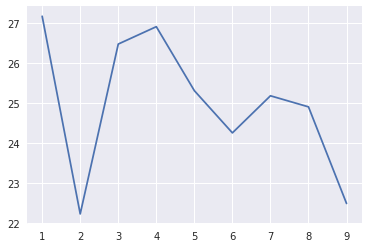

In [169]:
# examine where the angle between the two main eigenvectors for each gaussian comes from
comp1 = np.matmul(max_eigvec1.T, components)
norm_comp1 = np.asarray([(i**2)/sum([k**2 for k in comp1]) for i in comp1])
comp2 = np.matmul(max_eigvec2.T, components)
norm_comp2 = np.asarray([(j**2)/sum([k**2 for k in comp2]) for j in comp2])

print("main eigenvector for the first Gaussian: \n", norm_comp1)
print("main eigenvector for the second Gaussian: \n",norm_comp2)

angles = []
print("original angle", angle(norm_comp1, norm_comp2))
for i in range(len(norm_comp1)): # angle using only some components
    norm1 = [norm_comp1[j] if j != i else 0.0 for j in range(len(norm_comp1))]
    norm2 = [norm_comp2[j] if j != i else 0.0 for j in range(len(norm_comp2))]
    print("angle after dropping %s th component: " %(i+1), angle(np.asarray(norm1), np.asarray(norm2)))
    angles.append(angle(np.asarray(norm1), np.asarray(norm2)))
    
plt.plot(range(1,10), angles)
plt.show()
plt.close()

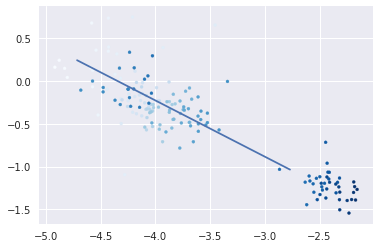

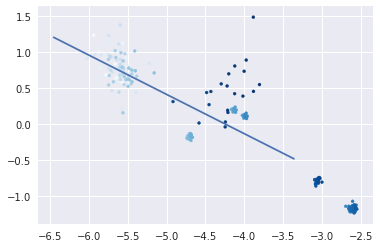

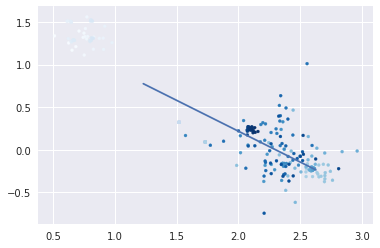

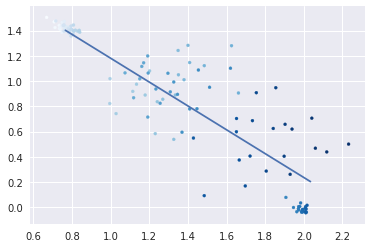

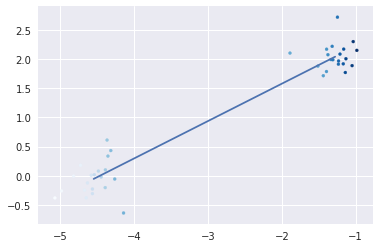

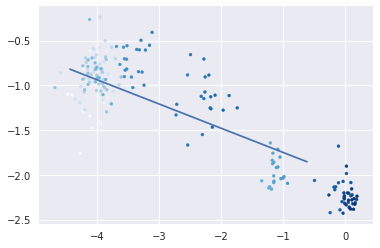

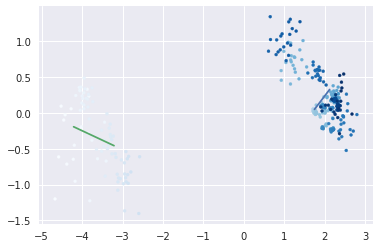

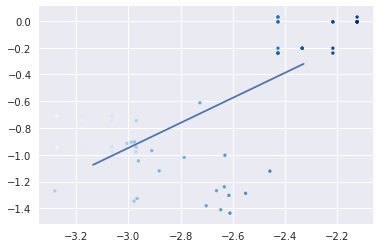

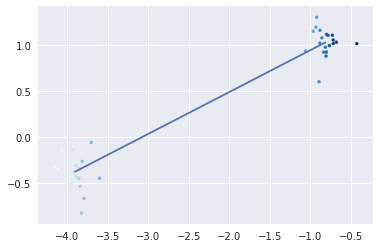

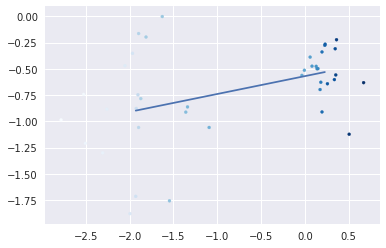

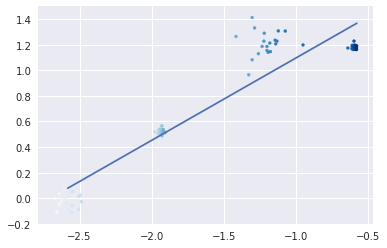

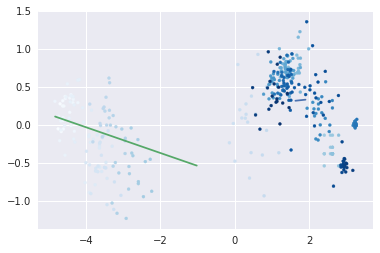

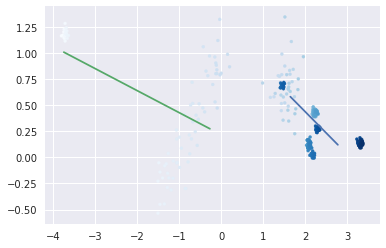

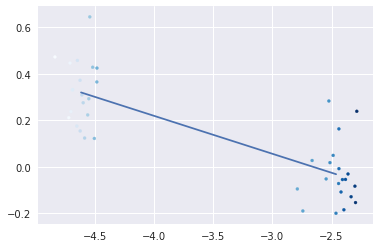

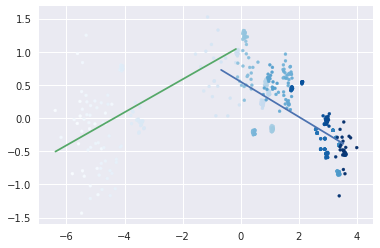

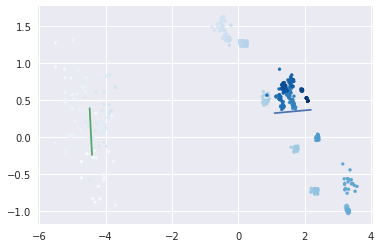

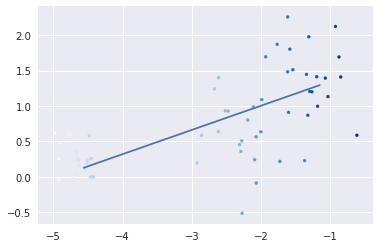

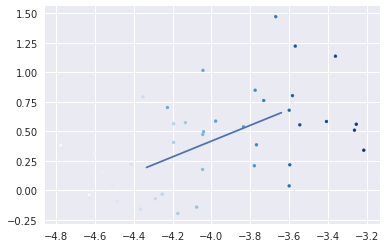

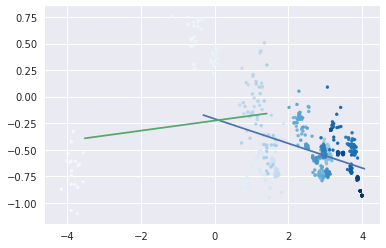

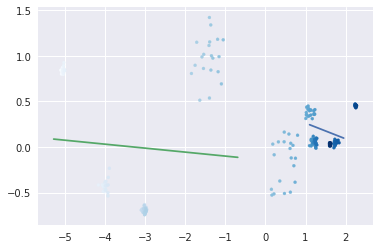

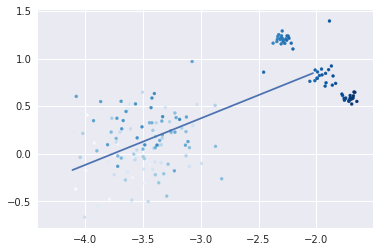

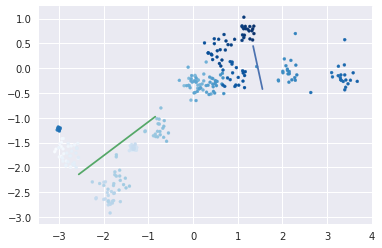

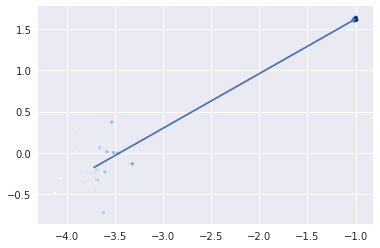

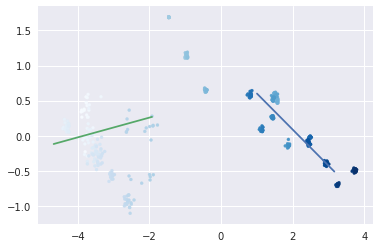

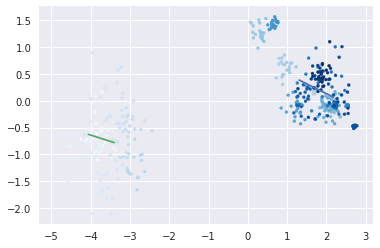

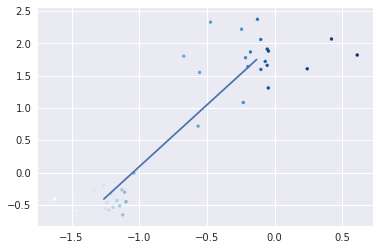

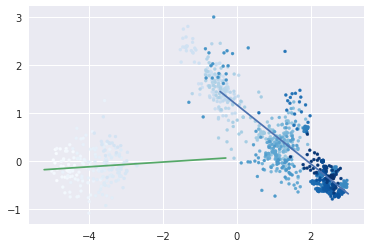

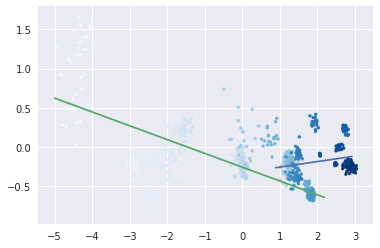

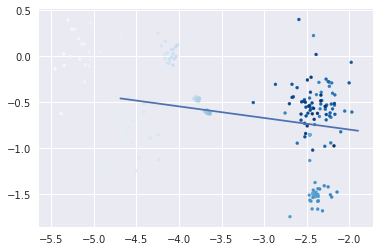

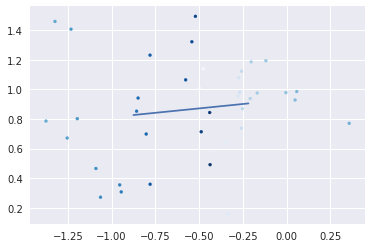

In [23]:
# flow vectors for each NGAs
nga_dict = {key:list() for key in ngas}
vec_coef1 = list() # coefficients for overall flow vectors for each ngas in the first gaussian
vec_ic1 = list() # intercept for overall flow vectors for each ngas in the first gaussian
vec_coef2 = list() # coefficients for overall flow vectors for each ngas in the second gaussian
vec_ic2 = list() # intercept for overall flow vectors for each ngas in the second gaussian

for idx in range(len(data)):
    nga = pnas_data1.loc[idx].NGA
    nga_dict[nga].append((data[:,0][idx], data[:,1][idx], times[idx][0], idx))            

for i in range(len(ngas)):  # flow vector for each NGA

    nga_pc1 = [p for p,_,_,_ in nga_dict[ngas[i]]] 
    nga_pc2 = [j for _,j,_,_ in nga_dict[ngas[i]]]
    nga_time = [k for _,_,k,_ in nga_dict[ngas[i]]]

    nga_pc1 = [x for _,x,_ in sorted(zip(nga_time, nga_pc1, nga_pc2))]
    nga_pc2 = [y for _,_,y in sorted(zip(nga_time, nga_pc1, nga_pc2))]

    nga_pc_gauss1 = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss1_idx]
    nga_pc_gauss2 = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss2_idx]

    nga_time1 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss1_idx])
    nga_time2 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss2_idx])

    xfit1 = np.linspace(-6, 4, len(nga_time1))
    xfit2 = np.linspace(-6, 4, len(nga_time2))

    assert len(nga_pc_gauss1) == len(nga_time1)
    assert len(nga_pc_gauss2) == len(nga_time2)
    
    #fit linear regression 
    if len(nga_time1) == 0:
        ols2 = linear_model.LinearRegression()
        model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)
                
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)
        
        yfit2 = model2.predict(np.sort(nga_time2).reshape(-1, 1))
        plt.plot([p for p, _ in yfit2], [q for _, q in yfit2])
        
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)
        
    elif len(nga_time2) == 0:
        ols1 = linear_model.LinearRegression()
        model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)
        
        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)
        
        yfit1 = model1.predict(np.sort(nga_time1).reshape(-1, 1))

        plt.plot([p for p, _ in yfit1], [q for _, q in yfit1])
        
        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)

    else:
        ols1 = linear_model.LinearRegression()
        model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)
        ols2 = linear_model.LinearRegression()
        model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)
        
        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)

        yfit1 = model1.predict(np.sort(nga_time1).reshape(-1, 1))
        yfit2 = model2.predict(np.sort(nga_time2).reshape(-1, 1))
        
        plt.plot([p for p, _ in yfit1], [q for _, q in yfit1])
        plt.plot([p for p, _ in yfit2], [q for _, q in yfit2])

        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)

    plt.scatter(nga_pc1, nga_pc2, s=9, c=range(len(nga_pc1)), cmap = 'Blues')
    plt.show()
    plt.close()
    
gauss1_coef = np.mean(vec_coef1, axis=0)
gauss1_ic = np.mean(vec_ic1, axis=0)
gauss2_coef = np.mean(vec_coef2, axis=0)
gauss2_ic = np.mean(vec_ic2, axis=0)

In [24]:
def draw_vector(v0, v1, ax=None, description = ''):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate(description, v1, v0, arrowprops=arrowprops)


In [25]:
# mark dots differently based on which of the two gaussians they belong

times = pnas_data1.loc[:, ['Time']].values

#fit GMM
gmm = GMM(n_components=2).fit(data)
cov = gmm.covariances_
prob_distr = gmm.predict_proba(data)

# determine to which of the two gaussians each data point belongs by looking at probability distribution 
gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] >= prob_distr[i][1]]
gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] >= prob_distr[j][0]]

gauss1_time = [times[i] for i in gauss1_idx] # time for the first gaussian data
gauss2_time = [times[j] for j in gauss2_idx] # time for the second gaussian data

gauss1_pc1 = [data[:,0][i] for i in gauss1_idx] # first pc values for the first gaussian
gauss2_pc1 = [data[:,0][j] for j in gauss2_idx] # first pc values for the second gaussian

gauss1_pc2 = [data[:,1][i] for i in gauss1_idx]
gauss2_pc2 = [data[:,1][j] for j in gauss2_idx]


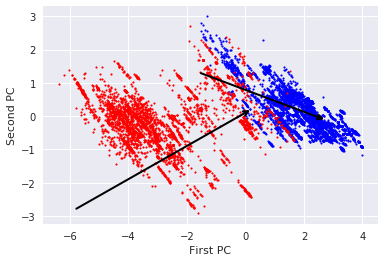

In [26]:

plt.scatter(gauss1_pc1, gauss1_pc2, s=3, c='b')
plt.scatter(gauss2_pc1, gauss2_pc2, s=3, c='r')

# X, Y = data[:, 0], data[:, 1]

# plt.scatter(X, Y, s=3)
# plt.title('scatter plot for two principal component values using all 20 imputed sets')
plt.xlabel('First PC')
plt.ylabel('Second PC')

gauss1_t = sorted(gauss1_time)
gauss2_t = sorted(gauss2_time)
ic1 = np.asarray([gauss1_ic]).T
ic2 = np.asarray([gauss2_ic]).T

def line_vec(time, coef, intercept):
    return [(coef*i+intercept) for i in time]

gauss1 = line_vec(gauss1_t, gauss1_coef, ic1)
gauss2 = line_vec(gauss2_t, gauss2_coef, ic2)

gauss1_x= [i for i,j in gauss1 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
gauss1_y= [j for i,j in gauss1 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
gauss2_x= [i for i,j in gauss2 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
gauss2_y= [j for i,j in gauss2 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]

plt.savefig('two_pc.png', transparent=True)
v0 = np.asarray([gauss1_x[0], gauss1_y[0]]); v1 = np.asarray([gauss1_x[-1], gauss1_y[-1]])
draw_vector(v0, v1)
v0 = np.asarray([gauss2_x[0], gauss2_y[0]]); v1 = np.asarray([gauss2_x[-1], gauss2_y[-1]])
draw_vector(v0, v1)
plt.savefig('dynamics.png', transparent=True)
plt.show()
plt.close()


In [ ]:
plt.scatter(gauss1_pc1, gauss1_pc2, s=3, c='b')
plt.scatter(gauss2_pc1, gauss2_pc2, s=3, c='r')

# X, Y = data[:, 0], data[:, 1]

# plt.scatter(X, Y, s=3)
# plt.title('scatter plot for two principal component values using all 20 imputed sets')
plt.xlabel('First PC')
plt.ylabel('Second PC')

gauss1_t = sorted(gauss1_time)
gauss2_t = sorted(gauss2_time)
ic1 = np.asarray([gauss1_ic]).T
ic2 = np.asarray([gauss2_ic]).T

def line_vec(time, coef, intercept):
    return [(coef*i+intercept) for i in time]

gauss1 = line_vec(gauss1_t, gauss1_coef, ic1)
gauss2 = line_vec(gauss2_t, gauss2_coef, ic2)

gauss1_x= [i for i,j in gauss1 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
gauss1_y= [j for i,j in gauss1 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
gauss2_x= [i for i,j in gauss2 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
gauss2_y= [j for i,j in gauss2 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]

plt.savefig('two_pc.png', transparent=True)
v0 = np.asarray([gauss1_x[0], gauss1_y[0]]); v1 = np.asarray([gauss1_x[-1], gauss1_y[-1]])
draw_vector(v0, v1)
v0 = np.asarray([gauss2_x[0], gauss2_y[0]]); v1 = np.asarray([gauss2_x[-1], gauss2_y[-1]])
draw_vector(v0, v1)
plt.savefig('dynamics.png', transparent=True)
plt.show()
plt.close()


[-0.32798649]
[ 0.49908719]
[ 0.78748373]
[ 0.113002]


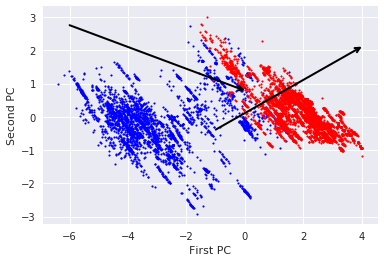

In [9]:


# flow vectors for each NGAs
nga_dict = {key:list() for key in ngas}
vec_coef1 = list() # coefficients for overall flow vectors for each ngas in the first gaussian
vec_ic1 = list() # intercept for overall flow vectors for each ngas in the first gaussian
vec_coef2 = list() # coefficients for overall flow vectors for each ngas in the second gaussian
vec_ic2 = list() # intercept for overall flow vectors for each ngas in the second gaussian

for idx in range(len(data)):
    nga = pnas_data1.loc[idx].NGA
    nga_dict[nga].append((data[:,0][idx], data[:,1][idx], times[idx][0], idx))            

for i in range(len(ngas)):  # flow vector for each NGA

    nga_pc1 = [p for p,_,_,_ in nga_dict[ngas[i]]] 
    nga_pc2 = [j for _,j,_,_ in nga_dict[ngas[i]]]
    nga_time = [k for _,_,k,_ in nga_dict[ngas[i]]]

    nga_pc1 = [x for _,x,_ in sorted(zip(nga_time, nga_pc1, nga_pc2))]
    nga_pc2 = [y for _,_,y in sorted(zip(nga_time, nga_pc1, nga_pc2))]

    nga_pc_gauss1 = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss1_idx]
    nga_pc_gauss2 = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss2_idx]

    nga_time1 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss1_idx])
    nga_time2 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss2_idx])

    xfit1 = np.linspace(-6, 4, len(nga_time1))
    xfit2 = np.linspace(-6, 4, len(nga_time2))

    assert len(nga_pc_gauss1) == len(nga_time1)
    assert len(nga_pc_gauss2) == len(nga_time2)
    
    #fit linear regression 
    if len(nga_time1) == 0:
        ols2 = linear_model.LinearRegression()
        model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)
                
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)
                
    elif len(nga_time2) == 0:
        ols1 = linear_model.LinearRegression()
        model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)
        
        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)

    else:
        ols1 = linear_model.LinearRegression()
        model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)
        ols2 = linear_model.LinearRegression()
        model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)
        
        vec_coef1.append(model1.coef_)
        vec_ic1.append(model1.intercept_)
        vec_coef2.append(model2.coef_)
        vec_ic2.append(model2.intercept_)

gauss1_coef = np.mean(vec_coef1, axis=0)
gauss1_ic = np.mean(vec_ic1, axis=0)
gauss2_coef = np.mean(vec_coef2, axis=0)
gauss2_ic = np.mean(vec_ic2, axis=0)

# slope and intercept of the average flow vector for each cluster
slope1 = gauss1_coef[1]/gauss1_coef[0]
slope2 = gauss2_coef[1]/gauss2_coef[0]
intercept1 = gauss1_ic[1] - ((slope1) * gauss1_ic[0])
intercept2 = gauss2_ic[1] - ((slope2) * gauss2_ic[0])

print(slope1); print(slope2)
print(intercept1); print(intercept2)
plt.scatter(gauss1_pc1, gauss1_pc2, s=3, c='b')
plt.scatter(gauss2_pc1, gauss2_pc2, s=3, c='r')

# plot flow vectors 
def line_vec(xlinspace, slope, intercept):
    return [(i, slope*i+intercept) for i in xlinspace]

gauss1 = line_vec(np.linspace(-6, 0), slope1, intercept1)
gauss2 = line_vec(np.linspace(-1, 4), slope2, intercept2)

gauss1_x, gauss1_y = zip(*gauss1)
gauss2_x, gauss2_y = zip(*gauss2)

v0 = np.asarray([gauss1_x[0], gauss1_y[0]]); v1 = np.asarray([gauss1_x[-1], gauss1_y[-1]])
draw_vector(v0, v1)
v0 = np.asarray([gauss2_x[0], gauss2_y[0]]); v1 = np.asarray([gauss2_x[-1], gauss2_y[-1]])
draw_vector(v0, v1)


plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.show()
plt.close()


In [5]:
# llinear discriminant analysis 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(n_components = 9)

gmm = GMM(n_components=2).fit(data_mat)
cov = gmm.covariances_
prob_distr = gmm.predict_proba(data_mat)
gauss_idx = [1 if prob_distr[i][0] >= prob_distr[i][1] else 0 for i in range(len(prob_distr))]

clf.fit(data_mat, gauss_idx)
print(clf.coef_)
print(clf.intercept_)

[[ -0.74845799  -0.07171503   0.58298941   0.56795804   0.48072429
    2.76441102  -3.43917529  17.10920242  -0.30440374]]
[ 3.76405587]


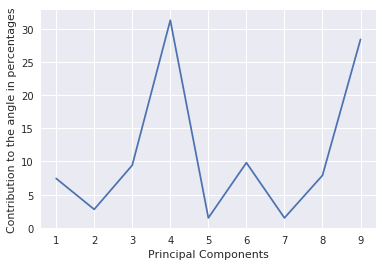

In [106]:
# what contributes to the angle 

y = [0.06630305, 0.0248204, 0.08419158, 0.2790867, 0.01331484, 0.08750921, 0.01332944, 0.07048244, 0.25338994]
y = [i/sum(y) * 100 for i in y]
assert sum(y) == 100
x = range(1, 10)

num_bins = 9

plt.plot(x, y)
plt.xlabel('Principal Components')
plt.ylabel('Contribution to the angle in percentages')
plt.savefig('angle plot', transparent=True)
plt.show()
plt.close()

In [208]:
# correlation coefficient

print(np.corrcoef(data_mat, rowvar = False)) # all the variables are highly correlated

[[ 1.          0.86505346  0.87251091  0.83268287  0.76321801  0.76582501
   0.73741739  0.78884865  0.69547295]
 [ 0.86505346  1.          0.76190804  0.75404044  0.67307376  0.64304264
   0.67919514  0.72251001  0.60834228]
 [ 0.87251091  0.76190804  1.          0.81726192  0.73290268  0.76184404
   0.68164495  0.74909918  0.62994575]
 [ 0.83268287  0.75404044  0.81726192  1.          0.7784226   0.75414872
   0.70493489  0.7775226   0.67925378]
 [ 0.76321801  0.67307376  0.73290268  0.7784226   1.          0.81630831
   0.72942368  0.80053801  0.63727844]
 [ 0.76582501  0.64304264  0.76184404  0.75414872  0.81630831  1.
   0.71512455  0.81645849  0.65614567]
 [ 0.73741739  0.67919514  0.68164495  0.70493489  0.72942368  0.71512455
   1.          0.90089464  0.6970739 ]
 [ 0.78884865  0.72251001  0.74909918  0.7775226   0.80053801  0.81645849
   0.90089464  1.          0.71778018]
 [ 0.69547295  0.60834228  0.62994575  0.67925378  0.63727844  0.65614567
   0.6970739   0.71778018  1. 

In [10]:
# flow vectors between the two clusters 

def flowvec_inbetween():
    #Gaussian Mixture Model 
    #fit GMM
    gmm = GMM(n_components=2).fit(data)
    cov = gmm.covariances_
    prob_distr = gmm.predict_proba(data)
    
    
    # determine to which of the two gaussians each data point belongs by looking at probability distribution 
    gauss_idx1 = [i for i in range(len(prob_distr)) if prob_distr[i][0] <= 0.9]
    gauss_idx2 = [i for i in range(len(prob_distr)) if prob_distr[i][1] <= 0.9]
    print(len(gauss_idx1))
    print(len(gauss_idx2))
    print(len(list(set(gauss_idx1) & set(gauss_idx2))))
    
    print(len([i for i in prob_distr if i[0] < i[1]]))
    
    # flow vectors for each NGAs
    nga_dict = {key:list() for key in ngas}
    vec_coef = list() # coefficients for overall flow vectors for each ngas between the two gaussian
    vec_ic = list() # intercept for overall flow vectors for each ngas between the two gaussian

    for idx in range(len(data)):
        nga = pnas_data1.loc[idx].NGA
        nga_dict[nga].append((data[:,0][idx], data[:,1][idx], times[idx][0], idx))            

    for i in range(len(ngas)):  # flow vector for each NGA

        nga_pc = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss_idx]
        nga_time = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss_idx])


        #fit linear regression 
        if len(nga_pc) != 0:
            ols = linear_model.LinearRegression()
            model = ols.fit(nga_time.reshape(-1,1), nga_pc)

            vec_coef.append(model.coef_)
            vec_ic.append(model.intercept_)
    
    return vec_coef, vec_ic

def calc_slope(vec_coef, vec_ic):
    # slope and intercept of the average flow vector for each cluster
    np.seterr(divide='ignore', invalid='ignore')
    
    gauss_coef = np.mean(vec_coef, axis=0)
    gauss_ic = np.mean(vec_ic, axis=0)

    slope = gauss_coef[1]/gauss_coef[0]
    intercept = gauss_ic[1] - ((slope) * gauss_ic[0])
    
    return slope[0], intercept[0]

# plt.scatter(gauss1_pc1, gauss1_pc2, s=3, c='b')
# plt.scatter(gauss2_pc1, gauss2_pc2, s=3, c='r')

# # plot flow vectors 
# def line_vec(xlinspace, slope, intercept):
#     return [(i, slope*i+intercept) for i in xlinspace]

# gauss = line_vec(np.linspace(-3, 2), slope, intercept)

# gauss1_x, gauss1_y = zip(*gauss1)
# gauss2_x, gauss2_y = zip(*gauss2)

# v0 = np.asarray([gauss1_x[0], gauss1_y[0]]); v1 = np.asarray([gauss1_x[-1], gauss1_y[-1]])
# draw_vector(v0, v1)
# v0 = np.asarray([gauss2_x[0], gauss2_y[0]]); v1 = np.asarray([gauss2_x[-1], gauss2_y[-1]])
# draw_vector(v0, v1)


# plt.xlabel('First PC')
# plt.ylabel('Second PC')
# plt.show()
# plt.close()


In [11]:
# resampling from flow vector of each NGAs 

pt = turchin.progress_timer(n_iter = 5000, description = 'average flow vector bootstrapping on NGAs')

# flow vectors for each NGAs
vec_coef, vec_ic = flowvec_inbetween()
orig_slope, orig_ic = calc_slope(vec_coef, vec_ic)

def bstr_nga_flow(vec_coef, vec_ic, n=5000):
    """
    Resample from the flow vector of each nga with respect to each clusters
    """
    slopes = []
    intercepts = []
    
    vec_coef = np.asarray(vec_coef)
    vec_ic = np.asarray(vec_ic) 
    
    for i in range(n):
        
        #resample
        resample = np.random.randint(0, len(vec_coef), size = len(vec_coef))
        resampled_coef = vec_coef[resample]
        resampled_ic = vec_ic[resample]
        
        # find the average flow vector for each cluster
        slope, ic = calc_slope(resampled_coef, resampled_ic)
        
        if not np.isnan(slope):
            slopes.append(slope)
            intercepts.append(ic)
        
        pt.update()
        
    return slopes, intercepts 

slopes, intercepts = bstr_nga_flow(vec_coef, vec_ic)
pt.finish()

# plot the histogram 
num_bins = 100

print(len(slopes))
# average flow vector for the first Gaussian after bootstrapping
n, bins, patches = plt.hist(slopes, num_bins, facecolor='blue', alpha=0.5)
plt.title('average slope of the flow vector between the two clusters')
plt.axvline(x=orig_slope, c= 'Black')
plt.xlabel('slope')
plt.ylabel('number of occurences')
plt.show()
plt.close()

# average flow vector for the second Gaussian after bootstrapping 
n, bins, patches = plt.hist(intercepts, num_bins, facecolor='blue', alpha=0.5)
plt.title('average intercept of the flow vector between the two clusters')
plt.axvline(x=orig_ic, c='Black')
plt.xlabel('intercept')
plt.ylabel('number of occurences')
plt.show()
plt.close()



average flow vector bootstrapping on NGAs: N/A% |/             | ETA:  --:--:--

5009
3302
31
4994


NameError: name 'gauss_idx' is not defined

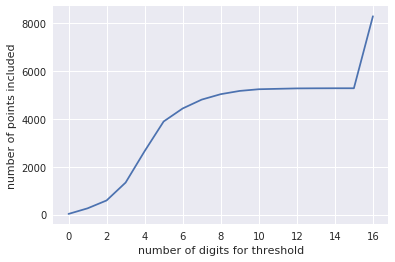

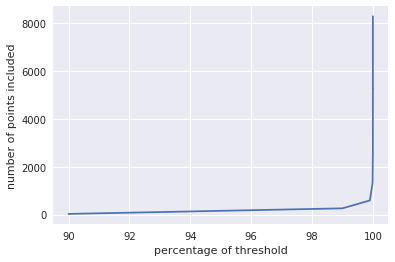

In [18]:
# find the data points within each NGA where each point has less than 90% of belonging to either of the clusters 

def flowvec_points(threshold):
    """
    Return the data points within each NGA where each point has less than 90% of belonging to either of the clusters
    """
    gmm = GMM(n_components=2).fit(data)
    cov = gmm.covariances_
    prob_distr = gmm.predict_proba(data)
    
    # determine to which of the two gaussians each data point belongs by looking at probability distribution 
    gauss_idx = [i for i in range(len(prob_distr)) 
                  if (prob_distr[i][0] <= threshold and prob_distr[i][1] <= threshold)]
    return gauss_idx

# flowvec_points(0.9)


idx_len = []
range_val = []
threshold = '0.9'

for i in range(100):
    thres = float(threshold)
    idx = flowvec_points(thres)
        
    idx_len.append(len(idx))
    range_val.append(thres)
    
    if len(idx) == 8280:
        break

    threshold += '9'
    
from math import *

plt.plot(range(len(range_val)), idx_len)
plt.xlabel('number of digits for threshold')
plt.ylabel('number of points included')
plt.show()
plt.close()

plt.plot([i*100 for i in range_val], idx_len)
plt.xlabel('percentage of threshold')
plt.ylabel('number of points included')
plt.show()
plt.close()
    

In [20]:
# find the transition point for each NGAs 

def gauss_idx(data_mat):
    """
    Label each point by which of the two Gaussians it has higher probability of belonging to
    """
    #Gaussian Mixture Model 
    #fit GMM
    gmm = GMM(n_components=2).fit(data_mat)
    cov = gmm.covariances_
    prob_distr = gmm.predict_proba(data_mat)

    # determine to which of the two gaussians each data point belongs by looking at probability distribution 
    if gmm.weights_[0] < gmm.weights_[1]:
        gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] >= prob_distr[i][1]]
        gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] >= prob_distr[j][0]]
    else:
        gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] <= prob_distr[i][1]]
        gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] <= prob_distr[j][0]]
        
    return gauss1_idx, gauss2_idx 

def rand_impute(orig_dataframe):
    """
    Given a set of 20 imputed sets combined, randomly sample to construct 1 set of data points for each polity/time
    """
    
    resample = [np.random.randint(0, 20) * 414 + i for i in range(414)]
    resampled_df = orig_dataframe.loc[resample]
    
    return resampled_df    
    
def between_vec(df):
    """
    Flow vectors between the two clusters for each NGA
    """    
    gauss1_idx, gauss2_idx = gauss_idx(data_mat)
    nga_dict = {key:list() for key in ngas}
    
    # compute flow vector for each nga 
    for nga in ngas:
        nga_idx = df.index[df['NGA'] == nga].tolist()
        
        transition1 = None
        # find the transition point
        for i in range(len(nga_idx)-1):
            if nga_idx[i] in gauss1_idx and nga_idx[i+1] in gauss2_idx:
                print(nga, i)
#                 break
#         prtint(transition1, len(nga_idx))
        j = 0

#         try:
#             while len(nga_dict[nga]) <= len(nga_idx):
#                 nga_dict[nga].append((data[:, 0][transition+j], data[:, 1][transition+j], times[transition+j]))

#                 if j != 0:
#                     nga_dict[nga].append((data[:, 0][transition-j], data[:, 1][transition-j]))

#                 j += 1 

#         except:
#             pass
    
resampled_df = rand_impute(pnas_data1)
    
    
    
    
    
    
    
    
    
#     # flow vectors for each NGAs
#     nga_dict = {key:list() for key in ngas}
#     vec_coef = list() # coefficients for overall flow vectors for each ngas between the two gaussian
#     vec_ic = list() # intercept for overall flow vectors for each ngas between the two gaussian

#     for idx in range(len(data)):
#         nga = pnas_data1.loc[idx].NGA
#         nga_dict[nga].append((data[:,0][idx], data[:,1][idx], times[idx][0], idx))            

#     for i in range(len(ngas)):  # flow vector for each NGA

#         nga_pc = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss_idx]
#         nga_time = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss_idx])

#         #fit linear regression 
#         if len(nga_pc) != 0:
#             ols = linear_model.LinearRegression()
#             model = ols.fit(nga_time.reshape(-1,1), nga_pc)

#             vec_coef.append(model.coef_)
#             vec_ic.append(model.intercept_)
    
#     return vec_coef, vec_ic


Int64Index([ 828, 7867,  830, 7041, 4558, 2489, 5388, 4147, 1250, 5391,
            ...
            6614, 2889, 2476, 2891, 2892, 1651, 1238, 6621, 4138, 1241],
           dtype='int64', length=414)
